# Νευρωνικά Δίκτυα και Ευφυή Υπολογιστικά Συστήματα
# 3η Εργαστηριακή Άσκηση - Image Captioning

Ομάδα 91:

*   Δημήτρης Καλαθάς 03118016
*   Δημήτρης Καλέμης 03118152
*   Δημήτρης Μπακάλης 03118163

## Εισαγωγή

Στη συγκεκριμένη εργαστηριακή άσκηση θα επιχειρήσουμε να δημιουργήσουμε ένα μοντέλο για παραγωγή captions σε εικόνες, βασιζόμενοι στο tutorial του Tensorflow "Image captioning with visual attention". Πιο συγκεκριμένα, θα επεκτείνουμε το προαναφερθέν tutorial, καθώς, στο πλαίσιο της εργασίας, θα χρησιμοποιηθεί διαφορετικό dataset (flickr30k-images-ecemod), μία νέα μετρική για το τελικό evaluation του μοντέλου (bleu score) και διάφορες βελτιστοποιήσεις στο transformer decoder μοντέλο που θα εκπαιδευτεί.

## Setup

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 17 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 13s (32.1 MB/s)
(Reading database ... 128208 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 128175 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.

In [ ]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.8.2
    Uninstalling tensorflow-datasets-4.8.2:
      Successfully uninstalled tensorflow-datasets-4.8.2


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.6 MB/s eta 0:00:00


In [ ]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

from nltk.translate.bleu_score import *

## Download the dataset

Αρχικά, θα κατεβάσουμε το ζητούμενο dataset, σύμφωνα με τον κώδικα που δίνεται από την εκφώνηση:

In [ ]:
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

4376381805/4376381805 [==============================] - 89s 0us/step


In [ ]:
# Download captions file
captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract=False)

# Download train files list
train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract=False)

# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract=False)

66196/66196 [==============================] - 0s 1us/step


In [ ]:
path="."
IMAGE_DIR="image_dir"
path = pathlib.Path(path)
   
captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
   
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
  cap_dict[fname].append(cap)
   
train_files = (path/train_files_list).read_text().splitlines()
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
   
test_files = (path/test_files_list).read_text().splitlines()
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]

train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

Παρακάτω φαίνεται η μορφή του dataset που θα επεξεργαστούμε. Πιο συγκεκριμένα αποτελείται από το path της κάθε εικόνας και 5 captions που την χαρακτηρίζουν.

In [ ]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [ ]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


## Image Feature Extractor - Encoder

Προκειμένου να παράξουμε όσο το δυνατόν καλύτερα features για τις εικόνες και να αποφύγουμε το επιπλέον κόστος εκπαίδευσης θα χρησιμοποιήσουμε transfer learning και, ειδικότερα, ένα pretrained μοντέλο στο imagenet. Το default μοντέλο που χρησιμοποιείται από το tutorial είναι το mobilenetV3small, ωστόσο εμείς θα χρησιμοποιήσουμε το efficientnetV2B3, λόγω της αυξημένης επίδοσής του. Προφανώς, θα ορίσουμε την παράμετρο include_top σε False, καθώς θέλουμε μόνο το feature extraction χωρίς το MLP που χρησιμοποιείται στο τέλος για classification.

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

efficientnet = tf.keras.applications.EfficientNetV2B0(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
efficientnet.trainable=False

efficientnet2 = tf.keras.applications.EfficientNetV2B3(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
efficientnet2.trainable=False

52606240/52606240 [==============================] - 0s 0us/step


Η παρακάτω συνάρτηση κάνει load μια εικόνα και την κάνει resize στο shape που έχουμε ορίσει.

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

Ένα παράδειγμα από τα features maps που παράγονται από το εκάστοτε μοντέλο είναι το ακόλουθο:

In [ ]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)
print(efficientnet(test_img_batch).shape)
print(efficientnet2(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)
(1, 7, 7, 1280)
(1, 7, 7, 1536)


## Text Tokenizer/Vectorizer

Στη συνέχεια, θα μετατρέψουμε τα captions σε sequences από integers χρησιμοποιώντας ένα TextVectorization layer του TensorFlow. Επιπλέον, πριν από αυτή τη μετατροπή θα πραγματοποιηθεί μία προεπεξεργασία των captions, κατά την οποία, όλοι οι χαρακτήρες γίνονται πεζοί, αφαιρόυνται ορισμένοι χαρακτήρες (σημεία στίξης κλπ) και προστίθεται το token '[START]' στην αρχή κάθε sequence και το token '[END]' στο τέλος.

In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

Πρωτού ορίσουμε τον tokenizer αυξήσαμε και το vocabulary_size από 5000, που ήταν η default τιμή του tutorial σε 10000, για να έχουμε πιο ακριβή  captions.

In [ ]:
vocabulary_size = 10000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)

Επομένως, κάνουμε adapt τον tokenizer στα train δεδομένα μας (αφού προηγηθεί ένα map ώστε να κρατήσουμε μόνο τα captions χωρίς τις εικόνες).

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Παρακάτω φαίνονται κάποια παραδείγματα του tokenizer:

In [ ]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'man', 'is']

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 732, 5, 2, 69, 4], [3, 2, 2708, 30, 4]]>

Τέλος, δημιουργούμε δύο mappings για να μπορούμε να μετατρέψουμε γρήγορα τις λέξεις σε indeces και το αντίστροφο.

In [ ]:
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

## Prepare the datasets

Στο πλαίσιο της προεπεξεργασίας των captions, θα προβάλλουμε σε ένα ιστόγραμμα τα μήκη (αριθμό λέξεων) τους, ώστε να μη λάβουμε υπόψη πολυ μικρές και πολύ μεγάλες προτάσεις, που θα επιδράσουν αρνητικά το μοντέλο μας.

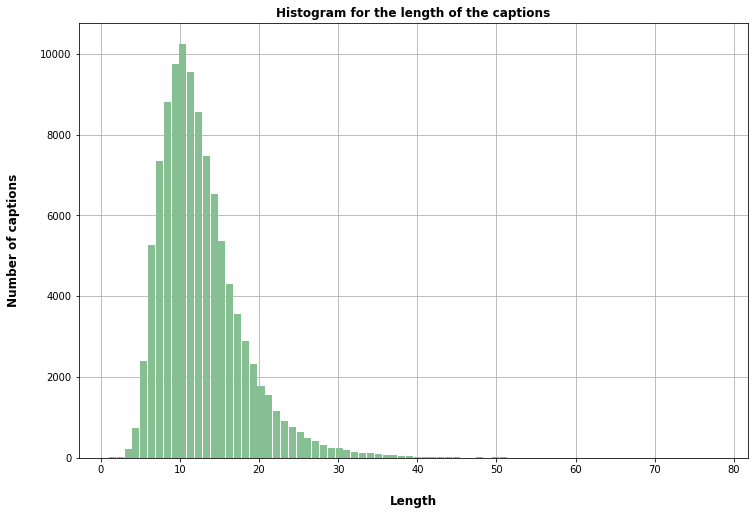

In [ ]:
import pandas as pd

captions_length = []
for data in train_captions:
  captions = data[1]
  for caption in captions:
    captions_length.append(len(caption.split()[:-1]))

df = pd.DataFrame(captions_length)
ax = df.hist(bins = max(captions_length), figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

for x in ax[0]:
  x.set_title("Histogram for the length of the captions", weight='bold', size=12)
  x.set_xlabel("Length", labelpad=20, weight='bold', size=12)
  x.set_ylabel("Number of captions", labelpad=20, weight='bold', size=12)

In [ ]:
filtered_train_captions = []
for path, captions in train_captions:
  img_captions = []
  for caption in captions:
    if 5 <= len(caption.split()[:-1]) <= 20:
      img_captions.append(caption)

  if len(img_captions) == 0:
    continue
  elif len(img_captions) < 5:
    for i in range(5-len(img_captions)):
      img_captions.append(img_captions[-1])

  filtered_train_captions.append((path, img_captions))

print(len(train_captions))
print(len(filtered_train_captions))

21000
20997


Επομένως, βάσει του παραπάνω ιστογράμματος, θα κρατήσουμε captions μήκους από 5 εώς 20 για την εκπαίδευση. Προκειμένου να έχουμε για κάθε εικόνα 5 captions, βάζουμε duplicates από valid captions (μήκος από 5 εώς 20) σε κάποια εικόνα η οποία έχει κάποιο invalid caption. Αν και τα 5 captions κάποιας εικόνας είναι invalid την αγνοούμε (κάτι που είναι εξαιρετικά σπάνιο όπως φαίνεται και από τα prints, καθώς μόλις 3 από τις 21,000 εικόνες δεν έχουν ούτε ένα valid caption). 

In [ ]:
train_raw = tf.data.experimental.from_list(filtered_train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

train_raw.element_spec

for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


In [ ]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## Transformer decoder model

Η υλοποίηση του μοντέλου βασίζεται, επίσης, στο tutorial του TensorFlow και αποτελείται από τα ακόλουθα κύρια μέρη:

1. Input -  Token embedding (δοκιμές με pretrained και trainable embeddings) και positional encoding (`SeqEmbedding`).
1. Decoder - Μία σειρά από decoder layers με το καθένα να αποτελείται από
   1. Ένα causal self attention layer (`CausalSelfAttention`)
   1. Ένα cross attention layer (`CrossAttention`)
   1. Ένα feed forward network (`FeedForward`)
1. Output - Ένα multiclass-classification μα βάση το vocabulary που χρησιμοποιείται.


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

Θα επεκτείνουμε το input του μοντέλου, προσθέτοντας τη δυνατότητα να να χρησιμοποιήσουμε τα glove-wiki pretrained embeddings (όταν η SeqEmbedding κληθεί με pretrained_embeddings=True). Συγκεκριμένα, αφού τα κατεβάσουμε, θα δημιουργήσουμε έναν πίνακα διαστάσεων 10000*300 (χρησιμοποιούνται τα embeddings μεγέθους 300 για όλες τις δοκιμές και έχουμε vocabulary size 10000), ενώ λέξεις, για τις οποίες δεν υπάρχει κάποιο embedding (πχ '[START]', '[END]'), αντιστοιχίζονται σε embedding με 300 μηδενικά.

In [ ]:
import gensim.downloader

#glove50 = gensim.downloader.load('glove-wiki-gigaword-50')
#glove100 = gensim.downloader.load('glove-wiki-gigaword-100')
#glove200 = gensim.downloader.load('glove-wiki-gigaword-200')
glove300 = gensim.downloader.load('glove-wiki-gigaword-300')

[=================================================-] 99.9% 375.8/376.1MB downloaded


In [ ]:
glove300_embeddings = []
for word in tokenizer.get_vocabulary():
  try:
    glove300_embeddings.append(glove300[word])
  except:
    glove300_embeddings.append(300*[0.])

glove300_embeddings = np.array(glove300_embeddings)

In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth, pretrained_embeddings, embeddings=glove300_embeddings):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.pretrained_token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        weights=[embeddings],
        trainable=False)
    
    self.add = tf.keras.layers.Add()
    self.pretrained_embeddings = pretrained_embeddings
    self.embeddings = embeddings

  def call(self, seq):
    if self.pretrained_embeddings:
      seq = self.pretrained_token_embedding(seq)
    else:
      seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

Το κάθε decoder layer που περιέχεται στο μοντέλο μας αποτελείται από 3 υπο-layers: ένα `CausalSelfAttention`, ένα `CrossAttention` κι ένα `FeedForward` δίκτυο. Και τα 3 φαίνονται παρακάτω:

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

Τα 3 αυτά υπο-layers συνδυάζονται για να αποτελέσουν το τελικό decoder layer, καθώς η έξοδος του ενός είναι είσοδος του άλλου (με τη σειρά που αναφέρθηκε παραπάνω).

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

Τέλος, έχουμε το output layer του μοντέλου, το οποίο παράγει τα τελικά predictions για κάθε επόμενη λέξη. Προφανώς, tokens όπως τα ('', '[UNK]', '[START]') δεν θέλουμε να παραχθούν σε κάποια πρόταση, όποτε τα ορίζουμε ως banned tokens. Επιπλέον, προκειμένου να έχουμε μια καλύτερη αρχικοποίηση του dense layer, αντί να θεωρήσουμε ότι το σύνολο των λέξεων ακολουθεί αρχικά ομοιόμορφη κατανομή, θα θέσουμε στο bias τους λογαρίθμους της πιθανότητας για κάθε token. Η διαφορά στο initial loss μετά τη συγκεκριμένη αρχικοποίηση φαίνεται και παρακάτω (uniform entropy συγκριτικά με marginal entropy).

In [ ]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [ ]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

3281it [02:58, 18.40it/s]


Uniform entropy: 9.21
Marginal entropy: 5.55


### Build the model

Για το τελικό μοντέλο θα συνδυάσουμε τα παραπάνω μέρη. Αναλυτικότερα, θα έχουμε:

1. Αρχικά, θα παράγονται τα features maps των εικόνων από τον feature extractor που έχει επιλεχθεί (efficientnetV2VB3 σε αυτή την περίπτωση) και το captions θα γίνουν tokenized.
2. Στη συνέχεια, θα έχουμε το SeqEmbedding layer, ώστε τα tokens να γίνουν vectors, μέσω των embeddings.
3. Έπειτα, τα embeddings και τα feature maps (αφού προηγηθεί flatten) θα περάσουν από τη σειρά των decoder layers που έχουμε ορίσει από το num_layers. 
4. Τέλος, το output layer θα παράξει ένα prediction (το οποίο με μία softmax γίνεται πιθανότητα όπως θα δούμε παρακάτω) για κάθε μία από τις λέξεις του vocabulary με βάση τη λέξη που έλαβε ως είσοδο.

In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, pretrained_embeddings, tokenizer, feature_extractor, output_layer, num_layers=1, embeddings=glove300_embeddings,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length,
        pretrained_embeddings=pretrained_embeddings,
        embeddings=embeddings)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer
    self.pretrained_embeddings = pretrained_embeddings
    self.embeddings = embeddings

In [ ]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')
     
    if txt.dtype == tf.string:
        # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)
    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [ ]:
model = Captioner(pretrained_embeddings=True, tokenizer=tokenizer, feature_extractor=efficientnet2, output_layer=output_layer,
                  units=300, dropout_rate=0.2, num_layers=2, num_heads=2)

### Generate captions

Σε αυτό το σημείο θα ασχοληθούμε με την παραγωγή των captions από το μοντέλο. Αρχικά, κατεβάζουμε μία εικόνα την οποία θα τεστάρουμε τόσο ως προς την επίδοση των διαφορετικών περιπτώσεων, όσο και ως προς τη διαδικασία εκπαίδευσης για να έχουμε ένα δείγμα της προόδου του μοντέλου.

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 0s 1us/step


Παρακάτω φαίνεται μία μέθοδος του captioner, η οποία παράγει την τελική πρόταση με βάση τα predictions του μοντέλου. Οι default περιπτώσεις του tutorial για την παραγωγή της τελικής πρότασης ήταν 3 και η διαφοροποίησή τους οφειλόταν στην τιμή του temperature. Πιο συγκεκριμένα οι περιπτώσεις ήταν οι εξής:

1. temperature=0: Σε αυτή την περίπτωση είχαμε greedy decoding, καθώς η επόμενη λέξη ήταν απλά αυτή με την μεγαλύτερη πιθανότητα δεδομένης της προηγούμενης.
2. 0 < temperature < 1: Όσο η τιμή του temperature αυξάνεται μεταβαίνουμε από greedy decoding σε τυχαία πρόβλεψη βάσει των logits.
3. temperature > 1: Όσο η τιμή ξεπερνάει και το 1, τόσο περισσότερο οι προβλέψεις μας θα ακολουθούν ομοιόμορφη κατανομή κατά μήκος του vocabulary.

Στις συγκεκριμένες περιπτώσεις προσθέσαμε και την επιλογή του beam search, καθώς, σύμφωνα με τη βιβλιογραφία, βελτιώνει αρκετά τις τελικές παραγόμενες προτάσεις. Αυτό συμβαίνει διότι με χρήση του beam search εξετάζουμε πιο καλά την κάθε πρόταση ως προς το σύνολό της και όχι απλά ως ένα σύνολο λέξεων, όπου η κάθε μία συνδέεται μόνο με την επομενή της. Σχετικά με την υλοποίηση του αλγορίθμου, αρχικοποιούμε τα tokens στο '[START]', που σηματοδοτεί την έναρξη της πρότασης και πραγματοποιούμε τα predictions για την επόμενη λέξη βάση των feature maps και των προηγούμενων λέξεων. Στη συνέχεια, περνάμε αυτά τα predictions από μία softmax (και μετά τα λογαριθμίζουμε), προκειμένου να μετατραπούν σε πιθανότητες. Ταξινομούμε τα πιθανά επόμενα tokens βάσει της πιθανότητάς τους και κρατάμε τα πρώτα b (παράμετρος του αλγορίθμου) μαζί με τις πιθανότητες τους. Για κάθε ένα από αυτά τα b γίνεται εκ νέου prediction και προκύπτουν επιπλέον b πιθανές νέες λέξεις. Στο τέλος της επανάληψης θα έχουμε b^2 πιθανά sequences, κρατάμε τα πρώτα b και επαναλαμβάνουμε τη διαδικασία αν σε κανένα από αυτά τα b η τελευταία λέξη δεν είναι το token '[END]'. Αντίθετα, αν κάποια από τα πιθανότερα sequences τελειώνει σε '[END]', προσθέτουμε σε μία (αρχικά κενή) λίστα την πρόταση και τη συνολική πιθανότητα της διά τον αριθμό λέξεων που περιέχει (όπως προτείνεται και στην εκφώνηση) και το αφαιρούμε από τα tokens που θα εξεταστούν στο επόμενο βήμα (χωρίς να μειώσουμε την τιμή του b). Όταν αυτή η λίστα φτάσει να αποκτήσει b στοιχεία κρατάμε ως αποτέλεσμα την πρόταση με την καλύτερη πιθανότητα (ανά λέξη).

In [ ]:
from tensorflow.python.ops.math_ops import scalar_mul
@Captioner.add_method
def simple_gen(self, image, beam_search, b=5, temperature=1):

  if beam_search:
    initial = self.word_to_index([b*['[START]']])
  else:
    initial = self.word_to_index([['[START]']]) # (batch, sequence)

  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  final_tokens = []

  for n in range(50):
    if beam_search:
      if n == 0:
        preds = self((img_features, tokens[:, 0:1])).numpy()  # (batch, sequence, vocab)
        preds = tf.nn.softmax(preds[:,-1, :]) #(batch, vocab)
        next = tf.cast(tf.argsort(preds, direction='DESCENDING')[:, :b], tf.int64)
        all_scores = tf.math.log(tf.sort(preds, direction='DESCENDING')[:, :b])
        tokens = tf.transpose(tf.concat([tokens, next], axis=0))

      else:
        all_scores = tf.convert_to_tensor([[]])
        for i, _ in enumerate(tokens):
          preds = self((img_features, tokens[i:i+1, :])).numpy()
          preds = tf.nn.softmax(preds[:,-1, :])
          b_next = tf.cast(tf.argsort(preds, direction='DESCENDING')[:, :b], tf.int64)
          b_scores = tf.math.log(tf.sort(preds, direction='DESCENDING')[:, :b])

          b_next = tf.reshape(b_next, shape=(b,1,1))
          previous = tf.convert_to_tensor(b*[tokens[i:i+1, :]])
          b_next = tf.concat([previous, b_next], axis=-1)

          if i==0:
            next = b_next
          else:
            next = tf.concat([next, b_next], axis=0)

          all_scores = tf.concat([all_scores, previous_scores[:, i]+b_scores], axis=-1)
        
        args = tf.argsort(all_scores, direction='DESCENDING')[:, :b]
        all_scores = tf.sort(all_scores, direction='DESCENDING')[:, :b]

        #ghj

        for i, arg in enumerate(args[0]):
          if i==0:
            tokens = next[arg, :, :]
          else:
            tokens = tf.concat([tokens, next[arg, :, :]], axis=0)

      flag = False
      cnt = 0
      for i in range(b):
        if tf.cast(tokens[cnt][-1], tf.int64) == self.word_to_index('[END]'):
          final_tokens.append([tokens[tf.newaxis, cnt, :], all_scores[0][cnt].numpy()/tokens[cnt, :].numpy().shape[0]])
          tokens = tf.concat([tokens[:cnt, :], tokens[cnt+1:, :]], axis=0)
          all_scores = tf.concat([all_scores[:, :cnt], all_scores[:, cnt+1:]], axis=1)
          cnt -= 1
          if len(final_tokens) == 5:
            flag = True
            break
        cnt += 1

      previous_scores = all_scores

      if flag:
        max = final_tokens[0][1]
        tokens = final_tokens[0][0]
        for sequence, score in final_tokens:
          if score > max:
            max = score
            tokens = sequence
        break

    else:  
      preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
      preds = preds[:,-1, :]

      if temperature==0:
          next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
      else:
          next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
      tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

      if next[0] == self.word_to_index('[END]'):
        break

  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Παρακάτω φαίνονται μερικά αποτέλεσμα (δεν έχει προηγηθεί η εκπαίδευση του μοντέλου) για τις 4 διαφορετικές περιπτώσεις που έχουμε για sentence generation.

In [ ]:
result = model.simple_gen(image, beam_search=True, temperature=0)
print('Beam search:')
print(result)
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, beam_search=False, temperature=t)
  print('Temperature = {}:'.format(t))
  print(result)

Beam search:

Temperature = 0.0:
a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
Temperature = 0.5:
a
Temperature = 1.0:
dribbling men city guy a a city playing in shirt throwing down a


## Train

Για να προχωρήσουμε στην εκπαίδευση του μοντέλου, αρχικά θα ορίσουμε τα ακόλουθα στοχεία:

- Loss function και μετρικές
- Optimizer
- Callbacks

### Losses and metrics

Στη διαδικασία της εκπαίδευσης θα χρησιμοποιηθούν: η default loss function (sparse softmax cross entropy) και η default μετρική masked accuracy, όπως προτείνεται στο tutorial του TensorFlow.

In [ ]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

Και στα callbacks δεν θα υπάρξει κάποια μεγάλη αλλαγή, καθώς στο τέλος κάθε εποχής θα γίνονται printed 3 captions για τιμές temperature = 0, 0.5, 1.0 (δεν προσθέσαμε και το αντίστοιχο caption μέσω beam search, για εξοικονόμηση χρόνου). Η μόνη αλλαγή που κάναμε ήταν να αυξήσουμε το patience του early stopping από 5 εποχές σε 20, ώστε να μη διακόπτεται πολύ νωρίς η εκπαίδευση.

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, beam_search=False, temperature=t)
      print(result)
    print()


In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a
on with asia standing playing s and an a a three eating wearing a in old river to a large himself



In [ ]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=20, restore_best_weights=True)]

### Train

Στη συνέχεια, κάνουμε compile και εκπαιδεύουμε το μοντέλο μας για 200 εποχές, χρησιμοποιώντας adam optimizer (με learning rate 0.0001) και τα losses, metrics, callbacks που αναφέρθηκαν παραπάνω.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [ ]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=200,
    callbacks=callbacks)

Epoch 1/200
100/100 [==============================] - ETA: 0s - loss: 5.1593 - masked_acc: 0.2178

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man in a a man in a red a busy


100/100 [==============================] - 58s 324ms/step - loss: 5.1593 - masked_acc: 0.2178 - val_loss: 4.8553 - val_masked_acc: 0.2462
Epoch 2/200
100/100 [==============================] - ETA: 0s - loss: 4.7288 - masked_acc: 0.2655

a man in a red shirt is is is is is in a red shirt is is in a red shirt is is is is in a red shirt is is is is is in a blue shirt is is is is in a red shirt is is is
a man is standing on a yellow
pretty plays and something

100/100 [==============================] - 27s 267ms/step - loss: 4.7288 - masked_acc: 0.2655 - val_loss: 4.7665 - val_masked_acc: 0.2562
Epoch 3/200
100/100 [==============================] - ETA: 0s - loss: 4.5578 - masked_acc: 0.2769

a man in a red shir

## Model Evaluation:

Για το τελικό evaluation του μοντέλου μας θα ορίσουμε δύο νέες συναρτήσεις, οι οποίες θα βρίσκουν το sentence bleu score (για ένα caption) και το corpus bleu score (για ένα corpus). Το bleu score είναι ένας σταθμισμένος μέσος όρος των unigrams (λέξεων), bigrams (δυάδα λέξεων), trigrams (τριάδα λέξεων) και fourgrams (τετράδα λέξεων) μεταξύ δύο captions.

In [ ]:
def sentence_bleu_score(hypothesis, references):
  hypothesis = hypothesis.split()
  for i, reference in enumerate(references):
    references[i] = str(reference).lower().split()[:-1]

  return sentence_bleu(references, hypothesis, weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=SmoothingFunction().method1)

In [ ]:
def corpus_bleu_score(hypotheses, references):
  for i, hypothesis in enumerate(hypotheses):
    hypotheses[i]= hypothesis.split()

  for i, image_references in enumerate(references):
    for j, reference in enumerate(image_references):
      references[i][j] = reference.decode("utf-8").lower().split()[:-1]

  return corpus_bleu(references, hypotheses, weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=SmoothingFunction().method1, auto_reweigh=False)

Για τις πρώτες 20 εικόνες του test set θα υπολογίσουμε τα captions τους για greedy και beam search, το bleu score για κάθε caption και θα προβάλλουμε την εικόνα για να τα συγκρίνουμε. Στο τέλος θα κάνουμε print και τον μέσο όρο των επιμέρους bleu scores (το οποίο ωστόσο δεν είναι ισοδύναμο με το corpus bleu) για greedy και beam search, αντίστοιχα. 

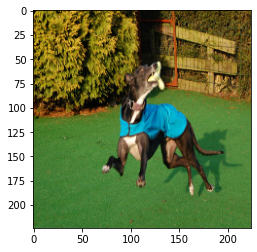

tf.Tensor(
[b'a black and white dog wearing a blue shirt carrying a toy in its mouth .'
 b'A brown dog with a blue suit on is playing with a toy over fake grass .'
 b'A dog in a blue sweater leaps while holding an object in its mouth .'
 b'The black dog is wearing a blue jacket and playing with a toy .'
 b'A dog wearing a blue sweater holds a yellow toy in its mouth .'], shape=(5,), dtype=string)
a black and white dog is jumping in the air
0.3141769459780237
a black and white dog is jumping in the air
0.3141769459780237



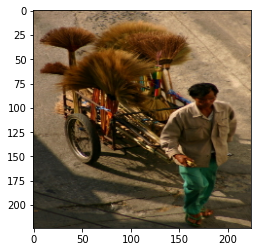

tf.Tensor(
[b'A man wearing aqua pants and matching flip-flops pulls a cart carrying handmade brooms through the street .'
 b'A man in a beige coat , green pants , and sandals is pulling a rickshaw with some items in it .'
 b'An Asian man in green pants is pulling a cart full of feathery flowery things .'
 b'A man wearing a brown shirt and green pans is pulling a rickshaw down a street'
 b'A man pulling his cart full of brooms .'], shape=(5,), dtype=string)
a man in a white shirt is pushing a cart down the street
0.2252943414528426
a man in a red shirt and white pants is pushing a cart
0.23188156021279738



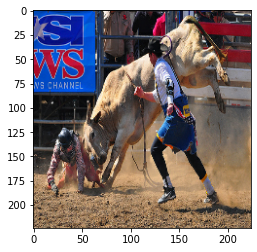

tf.Tensor(
[b'a large bull targets a man , inches away , in a rodeo with his horns , while a rodeo clown runs to help .'
 b'Two men are trying to rope in a bull who is crashing down on one of them , in a contest at a corral .'
 b'A man is running towards another man who is being attacked by a bucking bull .'
 b'A man being hit by a bull during an event , as another man runs to help .'
 b'The bulls wins , but not before it is stopped in its tracks .'], shape=(5,), dtype=string)
a man is riding a horse at a rodeo
0.13371456343954483
a man is riding a horse in a rodeo
0.2119233013282443



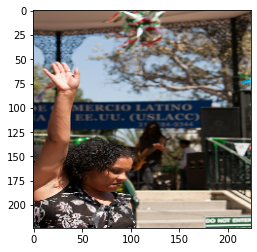

tf.Tensor(
[b'A Latino woman is standing outside raising her arm with a band playing in the background .'
 b'A Latin woman raising her hand in front of a band in the background .'
 b'A woman wearing a brown flowered dress is raising her hand .'
 b'A woman with curly hair is raising her hand on a street .'
 b'A woman dances next to a stage during a music festival .'], shape=(5,), dtype=string)
a man in a black shirt is playing a game
0.04839026487375216
a man in a black shirt and a woman in a purple shirt and a black shirt playing tennis
0.0286203885671615



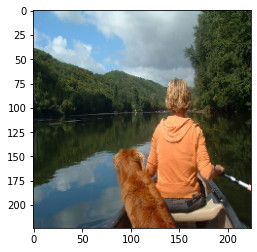

tf.Tensor(
[b'a woman wearing an orange jacket sitting in a canoe on a lake with a dog behind her'
 b'A person and their tan dog go for a ride in a rowboat .'
 b'A woman and a dog rowing down a wide river .'
 b'Woman and dog in rowboat on the water .'
 b'A woman with a dog canoe down a river .'], shape=(5,), dtype=string)
a brown dog is standing in a lake
0.16966971999266772
a dog is standing in a lake
0.19462459336210966



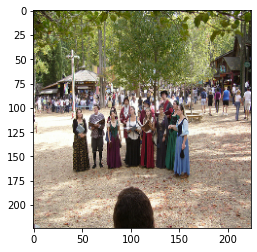

tf.Tensor(
[b'Several people in a semicircle are holding folders and singing in a wooded area with many people in the background .'
 b'A line of costumed figures hold opened books on the grounds where a Renaissance Fair is being held .'
 b'A group of people singing with books in their hands .'
 b'A group in costume sings at a renaissance fair .'
 b'A gypsy chorus of men and women .'], shape=(5,), dtype=string)
a group of people in a park
0.47929169699839874
a group of people are gathered around a large gathering
0.22395921914718733



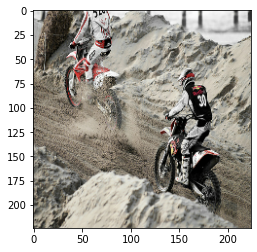

tf.Tensor(
[b'Two motocross bikers are throwing up dirt as they ride around a circuit .'
 b'Two dirtbikers are taking their motorbikes through a snowy path .'
 b'Two motor-cross riders race through dirty snow .'
 b'Two people in the middle of a dirt bike race .'
 b'Two bikers race uphill .'], shape=(5,), dtype=string)
a person riding a dirt bike on a dirt track
0.16972934934206227
a dirt bike rider is riding on a dirt bike
0.16972934934206227



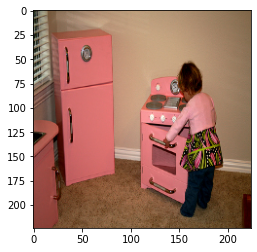

tf.Tensor(
[b'A small child playing with a toy oven in a mock kitchen at home .'
 b'A toddler is opening the oven door of a pink play kitchen set .'
 b'A child plays with a pink kitchen set that is child-sized .'
 b'A young girl plays in her pink toy kitchen .'
 b'A little girl playing with kitchen toys .'], shape=(5,), dtype=string)
a little girl is looking at a computer screen
0.12936052434034728
a girl in a pink shirt is holding a large piece of paper
0.11239266340074926



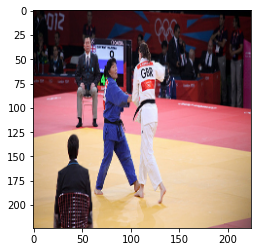

tf.Tensor(
[b'In the 2012 london olympics , two women , one from great britain are sparring in a match watched by two judges and many other people .'
 b'A woman in a blue karate uniform and a woman in a white karate uniform fight each other while two people wearing suits watch them .'
 b'Two women , one of them being from team Great Britain compete at the 2012 London Olympic games .'
 b"Two olympians compete in the women 's mixed martial arts event ."
 b'Two women engaged in a martial arts match before a crowd .'], shape=(5,), dtype=string)
a man in a red uniform and white uniform is practicing martial arts in a gym
0.11689419596152821
two men in a martial arts match
0.3960526117487448



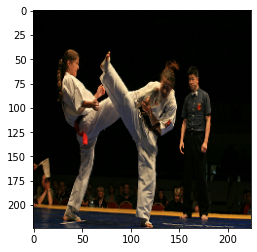

tf.Tensor(
[b'Two girls are kicking each other in martial arts uniforms .'
 b'Two women in their karate uniforms kick at one another .'
 b'Two people are performing karate at a tournament .'
 b'Girls fighting on karate competition .' b'Two woman are doing karate .'], shape=(5,), dtype=string)
two men practicing martial arts on a stage
0.12604665914201577
two men in white outfits are performing a dance
0.1099930547716519



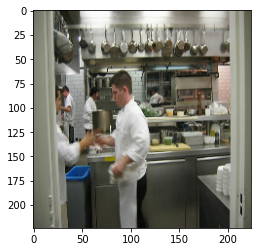

tf.Tensor(
[b"Several men in white chef 's jackets work in a kitchen ."
 b'A man in an apron is in a restaurant kitchen .'
 b'Inside the kitchen at a restaurant .'
 b'Two men in a kitchen fist pumping .'
 b'A group of men work in a kitchen .'], shape=(5,), dtype=string)
a man in a white shirt is cooking in a kitchen
0.24180262863945146
a chef is preparing food in a kitchen
0.2689083841831624



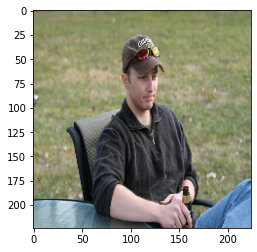

tf.Tensor(
[b'A young man in a black pullover and blue jeans sitting outside on a patio set having a beer .'
 b'A young man with a cap sitting outside drinking a beer .'
 b'A man is sitting at a table outside drinking a beer .'
 b'A man on patio furniture drinking a beer .'
 b'A man in a hat enjoys a beer .'], shape=(5,), dtype=string)
a man in a red shirt and blue jeans is sitting on the grass
0.2866073098280802
a man in a blue shirt and a hat is sitting on a lawn
0.259201993704651



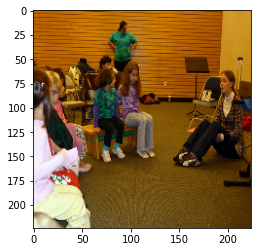

tf.Tensor(
[b'Small girls sit in benches a circle in a clapboard room - a slightly older girl wearing a white turtleneck sits on the carpet in front of them .'
 b'Several young girls sitting in chairs facing a young girl wearing pants and sweater sitting on floor'
 b'Young students sit in a circle and half pay attention to the teacher telling a story .'
 b'children are sitting in chairs with a music stand in the background .'
 b'Children in a group interacting .'], shape=(5,), dtype=string)
a group of young girls are playing instruments
0.18250587174781027
a group of people are sitting on a bench
0.13707303607347734



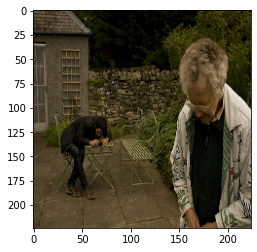

tf.Tensor(
[b'One man lays down on a lawn table in the background while an older lady stands , looking down in the foreground'
 b'A man is passed out asleep on a patio table while his mother looks down at the ground .'
 b'A man in black is sitting at a table taking a photo of an older woman on a patio .'
 b'An older lady walking by a man who is laying on the table looking at something .'
 b'A younger man takes a picture of what an older women stands over .'], shape=(5,), dtype=string)
a man in a white shirt and a black hat is standing next to a black dog
0.08415919950824476
a man in a white shirt and a black hat is standing next to a black dog
0.08415919950824476



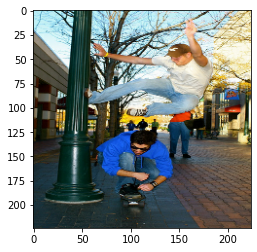

tf.Tensor(
[b'A guy dressed in jeans , a white t-shirt and brown hat is jumping over another guy who is riding a skateboard along a sidewalk in a shopping district .'
 b'A guy is karate kicking a light post while another dude wearing sunglasses is skateboarding underneath his outstretched leg .'
 b'A man is kicking a light pole while his friend crouches underneath him .'
 b'There is a man skateboarding and another nan jumping over his head .'
 b'One person using a light post to jump over another'], shape=(5,), dtype=string)
a child is jumping in the air
0.11098269528529414
a man in a white shirt jumps in the air
0.1595865633181411



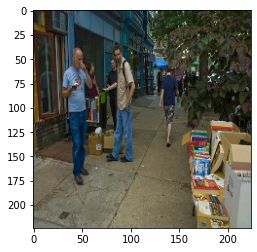

tf.Tensor(
[b'Two male individuals observing the contents of a table of books at a sidewalk sale .'
 b'Pedestrians are gazing at a display of books set out on a sidewalk under a tree .'
 b'A man wearing a blue shirt is thinking about which book he would like to buy .'
 b'The guy in blue shirt is looking at the books on the side of the street .'
 b'Some people are standing outside at a sidewalk book sale .'], shape=(5,), dtype=string)
a group of people are standing in front of a store
0.2550690687439064
a group of people are standing in front of a store
0.2550690687439064



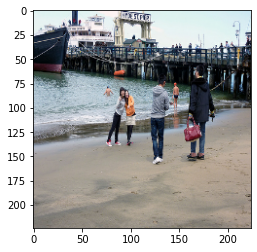

tf.Tensor(
[b'Two ladies getting their photo taken by a man in a light patterned hoodie while another man in a dark coat stands holding purses and observes .'
 b'Two Asian females are posing for a picture while a man appears to be carrying their bags .'
 b'Two young girls are standing in front of water posing for a camera .'
 b'Two friends get their picture taken in front of a large pier .'
 b'Two girls are hugging on a beach , in front of a boat .'], shape=(5,), dtype=string)
a group of people are standing on the beach
0.09269086604210161
a group of people are standing on the beach
0.09269086604210161



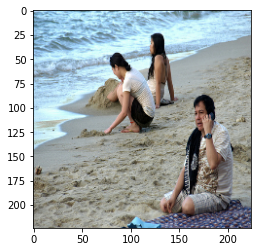

tf.Tensor(
[b'A man and two women are sitting on the beach , the man is wearing a watch and talking on his phone , while the women are building sand castles .'
 b'Two women and a man sit on the beach next to the water while the man wearing a watch talks on his phone .'
 b'Hispanic people sitting on the beach in the sand talking on the phone .'
 b'A man with a cellphone calling and two women are sitting on the beach'
 b'A man on a cellphone and two women at the seashore'], shape=(5,), dtype=string)
a man and a woman are sitting on the beach
0.6446932335649183
a young boy in a black shirt and shorts is playing with a beach
0.08422276175806641



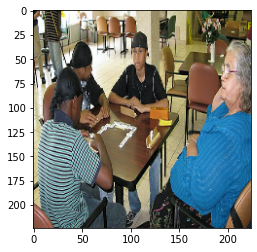

tf.Tensor(
[b'three boys visit their grandmother often at senior citizen home to play their favorite game scrabble .'
 b'Three African American males and one elderly female are playing Dominoes at a square table .'
 b'Three young men and an elderly lady are sitting at a table playing dominoes .'
 b'Three young men are playing dominoes while an older woman watches .'
 b'A game of dominoes is being played .'], shape=(5,), dtype=string)
a group of people are sitting at a table
0.5223324594383916
a group of people are sitting at a table
0.5223324594383916



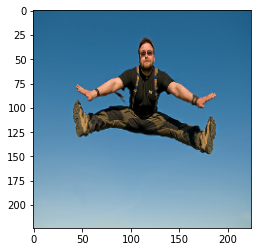

tf.Tensor(
[b'A man wearing suspenders and sunglasses leaps up in the air with his arms and legs spread out to the side .'
 b'A man wearing suspenders performs a split in midair .'
 b'A bearded man with glasses does a toe-touch .'
 b'A man jumps into the air .' b'A man jumping into the air'], shape=(5,), dtype=string)
a man in a black shirt is jumping in the air
0.20130516788893235
a man in a black shirt and a blue jeans is jumping in the air
0.15253394595095557

0.2267358381104157 0.20045659832899151


In [ ]:
beam_search_bleu = 0
greedy_bleu = 0
for image_path, references in test_raw.take(20):
  image = load_image(image_path)
  plt.imshow(image.numpy().astype(np.uint8))
  plt.show()
  references1 = references.numpy().tolist()
  references2 = references1.copy()
  print(references)
  hypothesis1 = model.simple_gen(image, beam_search=True, temperature = 0.0)
  hypothesis2 = model.simple_gen(image, beam_search=False, temperature = 0.0)
  
  print(hypothesis1)
  bleu = sentence_bleu_score(hypothesis1, references1)
  beam_search_bleu += bleu
  print(bleu)
  print(hypothesis2)
  bleu = sentence_bleu_score(hypothesis2, references2)
  greedy_bleu += bleu
  print(bleu)
  print()

beam_search_bleu /= 20
greedy_bleu /= 20
print(beam_search_bleu, greedy_bleu)

Τέλος, θα υπολογίσουμε το corpus bleu για τις πρώτες 1000 εικόνες του dataset με greedy και beam search.

Με greedy search προκύπτει το παρακάτω αποτέλεσμα:

In [ ]:
total_references= []
total_hypotheses = []
for image_path, references in test_raw.take(1000):
  image = load_image(image_path)
  hypothesis = model.simple_gen(image, beam_search=False, temperature = 0.0)
  total_references.append(references.numpy())
  total_hypotheses.append(hypothesis)

In [ ]:
print('Corpus bleu with greedy search:', corpus_bleu_score(total_hypotheses, total_references))

Corpus bleu with greedy search: 0.2950425436231815


Με beam search προκύπτει το παρακάτω αποτέλεσμα:

In [ ]:
total_references = []
total_hypotheses = []
for image_path, references in test_raw.take(1000):
  image = load_image(image_path)
  hypothesis = model.simple_gen(image, beam_search=True, temperature = 0.0)
  total_references.append(references.numpy())
  total_hypotheses.append(hypothesis)

In [ ]:
print('Corpus bleu with beam search:', corpus_bleu_score(total_hypotheses, total_references))

Corpus bleu with beam search: 0.30204123188771653


Σχετικά με τη διαδικασία εκπαίδευσης του μοντέλου μας τα loss και accuracy plots είναι τα παρακάτω:

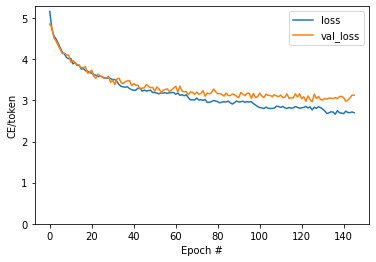

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

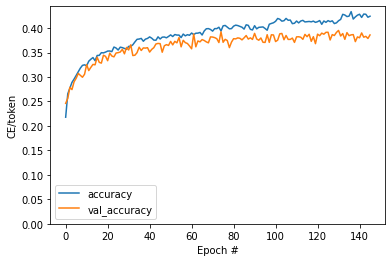

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Παρατηρήσεις - Σχολιασμός

**Σχετικά με την αρχιτεκτονική και την εκπαίδευση του μοντέλου:**

- Ως encodes δοκιμάσαμε το MobileNet που προυπήρχε, το EfficientNetB3 και το EfficientNetV2B3 και όπως ήταν αναμενόμενο τα καλύτερα αποτελέσματα προέκυψαν από το τελευαταίο, το οποίο είχε και καλύτερο accuracy στο imagenet.

- Το vocabulary size αυξήθηκε από 5000 σε 10000 για τη βελτιστοποίηση των captions, ενώ όσα captions είχαν λιγότερες από 5 ή περισσότερες από 20 λέξεις κόπηκαν.

- Ως embeddings χρησιμοποιήθηκαν, τόσο τα έτοιμα glove-wiki-300 (προφανώς είχαν καλύτερο αποτέλεσμα από τα αντίστοιχα μεγέθους 50, 100 και 200), όσο και trainable, χωρίς να επηρεάζουν ιδιαίτερα την απόδοση του μοντέλου (τα pretrained είχαν ελαφρώς καλύτερο bleu score).

- Συνολικά χρησιμοποιήθηκαν μόνο 2 decoder layers για λόγους ταχύτητας της εκπαίδευσης, ενώ, προφανώς, η επίδοση θα σημείωνε σημαντική αύξηση με περισσότερα.

- Για την τελική παραγωγή προτάσεων, τόσο ο greedy αλγόριθμος, όσο και o beam search είχαν αρκετά ικανοποιητικό bleu score, με τον beam search να υπερτερεί για λίγο.

- Η εκπαίδευση του μοντέλου αυξήθηκε από 100 σε 200 εποχές (γύρω στην 140-150 είχαμε early stopping) και το patience από 10 σε 20, προκειμένου το μοντέλο να εκπαιδευτεί όσο το δυνατόν καλύτερα.

**Ικανοποιητικά και άστοχα αποτελέσματα:**

Όπως φαίνεται και στις 20 εικόνες που προβάλλαμε παραπάνω, τα bleu scores των captions παρουσίαζαν σημαντική απόκλιση από εικόνα σε εικόνα (επιτυχημένα ή αποτυχημένα captions) ή ακόμα και στην ίδια εικόνα (caption με greedy σε σχέση με beam search). 

Πιο συγκεκριμένα:

- Ένα παράδειγμα αποτυχημένου caption (το οποίο αποτυπώνεται και στο bleu score) είναι η 4η εικόνα από τις 20, όπου ένα από τα references είναι "A Latino woman is standing outside raising her arm with a band playing in the background.", ενώ τα δύο captions είναι τα "a man in a black shirt is playing a game" (με bleu score 0.048) και "a man in a black shirt and a woman in a purple shirt and a black shirt playing tennis" (με bleu score 0.028)

- Ένα παράδειγμα επιτυχημένου caption (το οποίο αποτυπώνεται και στο bleu score) είναι η προτελευταία εικόνα, όπου ένα από τα references είναι "Three young men and an elderly lady are sitting at a table playing dominoes.", ενώ τα δύο captions είναι ίδια "a group of people are sitting at a table" και έχουν bleu score 0.522.

- Από την άλλη ένα παράδειγμα στο οποίο ο beam search έχει αισθητά καλύτερο αποτέλεσμα από τον greedy αλγόριθμο είναι το 3ο από το τέλος, όπου ένα reference είναι "A man with a cellphone calling and two women are sitting on the beach" και με beam search "a man and a woman are sitting on the beach" με bleu score 0.644, ενώ με greedy έχουμε "a young boy in a black shirt and shorts is playing with a beach" με bleu score 0.084.

- Υπάρχει και παράδειγμα στο οποίο ο greedy έχει αισθητά καλύτερο αποτέλεσμα από τον beam search (το ότι το μοντέλο μπορεί να δίνει μεγαλύτερη πιθανότητα σε ένα sequence από ένα άλλο δεν σημαίνει αναγκαία ότι αυτό το sequence θα έχει και μεγαλύτερο bleu score, άσχετα αν συνήθως αυτό ισχύει). Ένα τέτοιο παράδειγμα είναι η πρώτη από τις δύο εικόνες με πολεμικές τέχνες κι έχει reference "Two women engaged in a martial arts match before a crowd.". Ο beam search προβλέπει caption "a man in a red uniform and white uniform is practicing martial arts in a gym" με bleu score 0.116, ενώ ο greedy προβλέπει caption "two men in a martial arts match" με  bleu score 0.396. Όπως φαίνεται, μπορεί το bleu score να διαφέρει αρκετά, λόγω των διαφορετικών n-grams, ωστόσο πρόκειται για δύο σχετικά κοντινά και σχετικά καλά captions.
